In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
import os
import datetime
import pytz       # needed in order to deal with timezones

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn      # sklearn.__version__ = 0.24.1   !
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf

import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [ ]:
sklearn.__version__

'0.24.1'

# Utils

In [ ]:
# CONSTANTS

# hours per relevant time periods
sec_per_hour = 3600
hrs_per_day = 24
hrs_per_week = 7 * hrs_per_day
hrs_per_year = hrs_per_day * 365.2524

# 'month' is defined from year
hrs_per_month = hrs_per_year / 12

hours_periods = [hrs_per_day, hrs_per_week, hrs_per_month, hrs_per_year]

# list of pandas strings designating hourly, daily, weekly, montlhy and yearly periods
periods_list = ['H', 'D', 'W-MON', 'M', 'Y']

periods_dict = dict(zip(periods_list[1:], hours_periods))


# FUNCTIONS


def drop_nan_cols(dataframe):
    ''' Automatically drops those columns from a dataframe
        which are entirely filled with NaN's
    '''
    for col in list(dataframe):
        res = len(dataframe[col]) == dataframe[col].isnull().sum()
        if res:
            dataframe = dataframe.drop(col, axis=1)
    return dataframe


def convert_to_tz(dataframe, local_tz, target_tz):
    ''' Converts the dataframe's timedate values from local
        timezone local_tz to the desired timezone target_tz
    '''
    # we want to make sure that passed timezones exist in pytz's list of strings
    assert (local_tz in pytz.all_timezones) & (target_tz in pytz.all_timezones)

    # make a 1D array of Bool False values...
    infer_dst = np.array([False] * dataframe.shape[0])
    # ...to help tz_localize manage ambiguous datetimes
    df_converted = dataframe.dt.tz_localize(local_tz, 
                                    ambiguous=infer_dst
                                    ).dt.tz_convert(target_tz)
    # delete the last 6 chars correpsonding to "+xx:xx" and convert back to datetime
    df_converted = pd.to_datetime(df_converted.astype(str).apply(lambda x: x[:-6]),\
                                infer_datetime_format=True)
    return df_converted


def index_periods(datetime_index, periods_list):
    ''' Turns a DatetimeIndex datetime_index into a list of index period
        basd on given list of periods periods_list
    '''
        # ADD: assert DatetimeIndex and periods_list (of strings)
    return [datetime_index.to_period(period) for period in periods_list]


def data_to_periods(data, period_indxs):
    return [data.set_index(indx_per).groupby(['Datetime']).count().sort_values(by=['Datetime']).rename(columns={'Type': 'Call_volume'}) for indx_per in period_indxs]


def plot_periods(calls_data_list):
    for data in calls_data_list:
        data.plot(title='Resolution: ' + data.index.freqstr, figsize=(30, 5))


def osc_to_cartesian(dataset, column, periods_dict):
    ''' Creates columns as cos and sin of the given column using periods from periods_dict.   
    '''
    funcs = {'cos': np.cos, 'sin': np.sin}
    for key, fun in funcs.items():
        for per_str, period in periods_dict.items():
            dataset[per_str + '_' + key] = fun(column * (2 * np.pi / period))
    return dataset

# Inject and prepare the data

## Calls data

In [ ]:
calls_path = os.path.abspath("Seattle_Real_Time_Fire_911_Calls.csv")
#calls_path_dr = os.path.abspath("/content/drive/MyDrive/NiologicCodingChallenge/Seattle_Real_Time_Fire_911_Calls.csv")

In [ ]:
data_raw = pd.read_csv(calls_path, usecols=['Datetime', 'Type'])
print(data_raw.head(), '\n')
print(data_raw.info())

           Type                Datetime
0      Car Fire  05/22/2019 12:55:00 PM
1  Aid Response  05/22/2019 12:55:00 PM
2  Aid Response  05/22/2019 12:57:00 PM
3  Aid Response  07/01/2019 07:45:00 AM
4      Unk Odor  07/01/2019 07:45:00 AM 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534385 entries, 0 to 1534384
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Type      1534385 non-null  object
 1   Datetime  1534385 non-null  object
dtypes: object(2)
memory usage: 23.4+ MB
None


Initial observations:

*   Datetime is most likely given in local time of Seattle (since the data is downloaded from Seattle's City webpage). This means there could be daylight savings (DST) shifts in the data, in addition to the specific timezone shift. If that is true, some hours could appear to have more or less calls than the actual hour period of time does.
We cannot know in advance if this has a significant effect at hourly sampling resolution. In order to avoid this ambiguity and to make it compatible with the weather data, it's best to convert this column to UTC time, which is innert to DST and eliminates the timezone information. When predicting the calls on a day or hour, the dates can easily be converted back to whichever time one needs (PST or PDT for Seattle).
In this way the method also gains more generality.

*   There are several types of calls. For a deeper analysis of data we could group the data by call types and investigate them separately further. But we keep things simple for now and do not distinguish between the call types, unless otherwise specified.


### Correct for the Daylight Savings Time and convert to UTC time standard

First we convert the Datetime values to datetime64 type:

In [ ]:
data_raw['Datetime'] = pd.to_datetime(data_raw['Datetime'], infer_datetime_format=True)
data_raw = data_raw.sort_values(by=['Datetime']).reset_index(drop=True)
print(data_raw.head(), '\n')
print(data_raw.info())

                  Type            Datetime
0       Medic Response 2003-11-07 09:30:48
1       Medic Response 2003-11-07 09:31:47
2      Auto Fire Alarm 2003-11-07 09:43:15
3          1RED 1 Unit 2003-11-07 09:50:05
4  Aid Response Yellow 2003-11-07 09:56:10 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534385 entries, 0 to 1534384
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Type      1534385 non-null  object        
 1   Datetime  1534385 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 23.4+ MB
None


In [ ]:
print(f'The data spans the following time period: {data_raw.Datetime.min()} - {data_raw.Datetime.max()}')

The data spans the following time period: 2003-11-07 09:30:48 - 2021-02-06 16:09:00


Let's find the DST shift for year 2013 by hand, in order to examine the possible issue with DST shift.

In [ ]:
# manually pinpoint the DST shift on March 10, 2013
data_raw[(data_raw['Datetime'].dt.year == 2013) & (data_raw['Datetime'].dt.month == 3) & (data_raw['Datetime'].dt.day == 10) & (data_raw['Datetime'].dt.hour > 0) & (data_raw['Datetime'].dt.hour < 4)][8:15]

,Type,Datetime
757164,Auto Fire Alarm,2013-03-10 01:49:21
757165,Aid Response,2013-03-10 01:51:22
757166,Illegal Burn,2013-03-10 01:54:50
757167,Aid Response Yellow,2013-03-10 03:00:18
757168,Aid Response,2013-03-10 03:22:38
757169,Aid Response,2013-03-10 03:24:33
757170,Aid Response,2013-03-10 03:27:01


Note that calls for hours 02:xx:xx do not exist bewteen the call 757166 and 757167. This date and 02:00:00 time is the actual DST shift point. On such dates the documented hours are shifted, producing some ambiguous or nonexistent times, which affects the sampling horly rate. So let's fix that now.

First recognize the 'Datetime' column as the local Seattle Pacific Standard/Daylight Time, and then convert it to UTC. This is done using our ```convert_to_tz()``` function from ```utils.py``` which takes care of the DST issue as well. This function also eliminates a surplus "+00:00" timestamp.

In [ ]:
# local timezone of the city
local_tz = 'PST8PDT'
# set the target 'zone' to UTC
target_tz = 'UTC'

# use the custom function to eliminate the timezone and switch to UTC
data_raw['Datetime'] = convert_to_tz(data_raw['Datetime'], local_tz, target_tz)

Set the new UTC Daytime column as index:

In [ ]:
calls_data = data_raw.set_index('Datetime')
indx = calls_data.index
print(calls_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1534385 entries, 2003-11-07 17:30:48 to 2021-02-07 00:09:00
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Type    1534385 non-null  object
dtypes: object(1)
memory usage: 23.4+ MB
None


### Create indexes with different resolution


In [ ]:
# use custoom function to generate a list of period indexes out of calls_data index
period_indxs = index_periods(indx, periods_list)

Using other index periods we can count the call volume at different resolutions:

In [ ]:
# generate a list of calls data sampled with different periods resolution in the index
calls_data_list = data_to_periods(calls_data, period_indxs)

print(list(map(len, calls_data_list)))

[150769, 6303, 901, 208, 19]


We will be using the hourly sampled data:

In [ ]:
calls_data_H = calls_data_list[0]
calls_data_H.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 150769 entries, 2003-11-07 17:00 to 2021-02-07 00:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Call_volume  150769 non-null  int64
dtypes: int64(1)
memory usage: 2.3 MB


### Visualize the data

Plot the number of calls in different resolution:

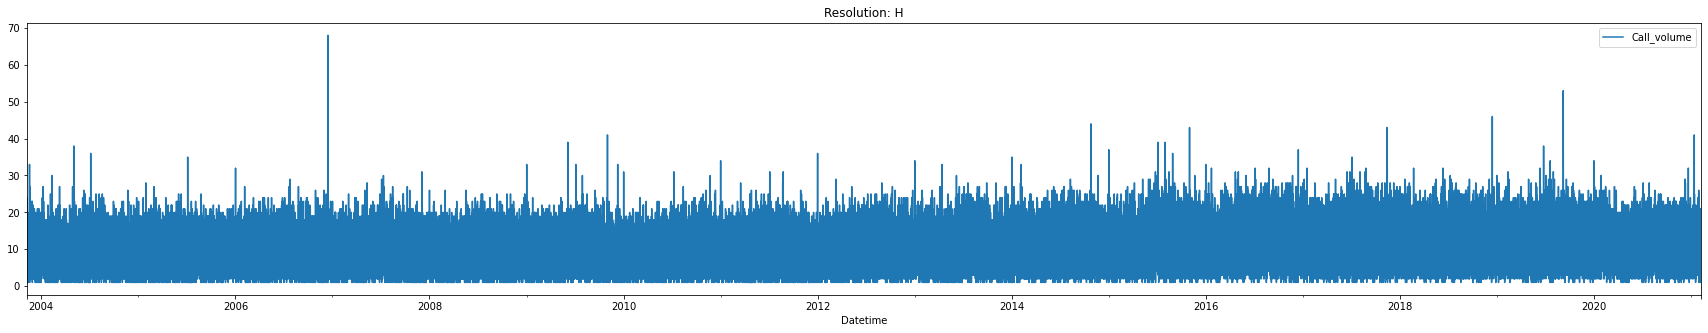

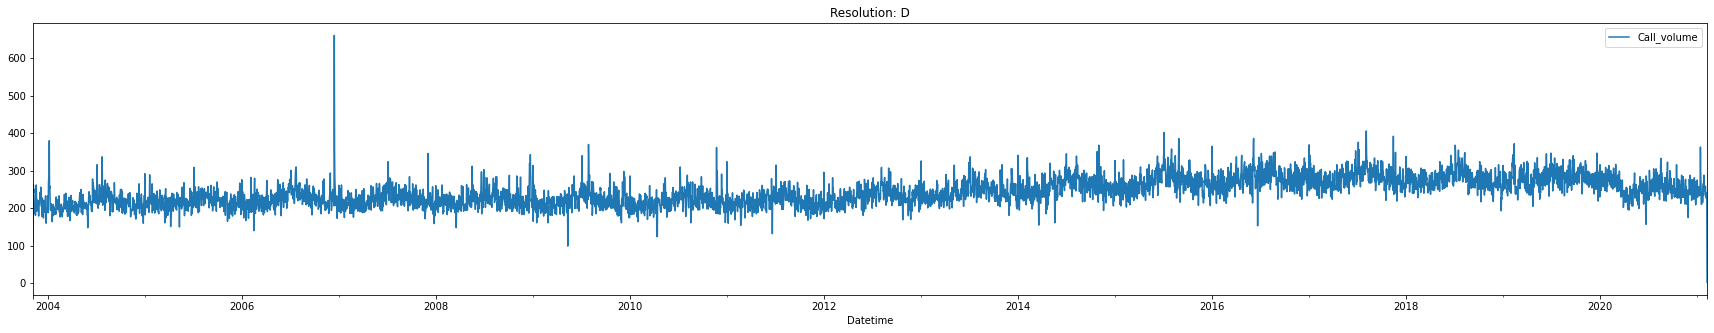

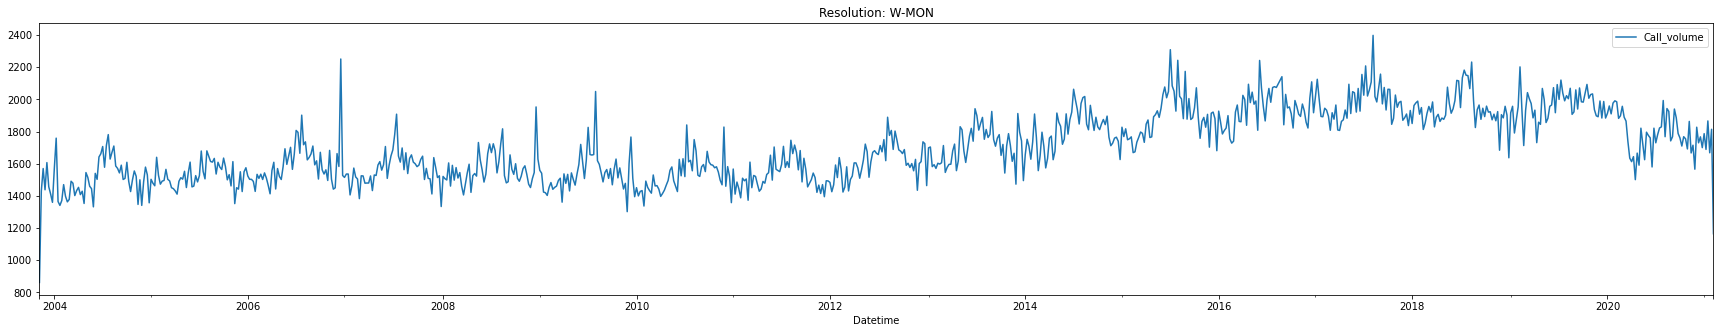

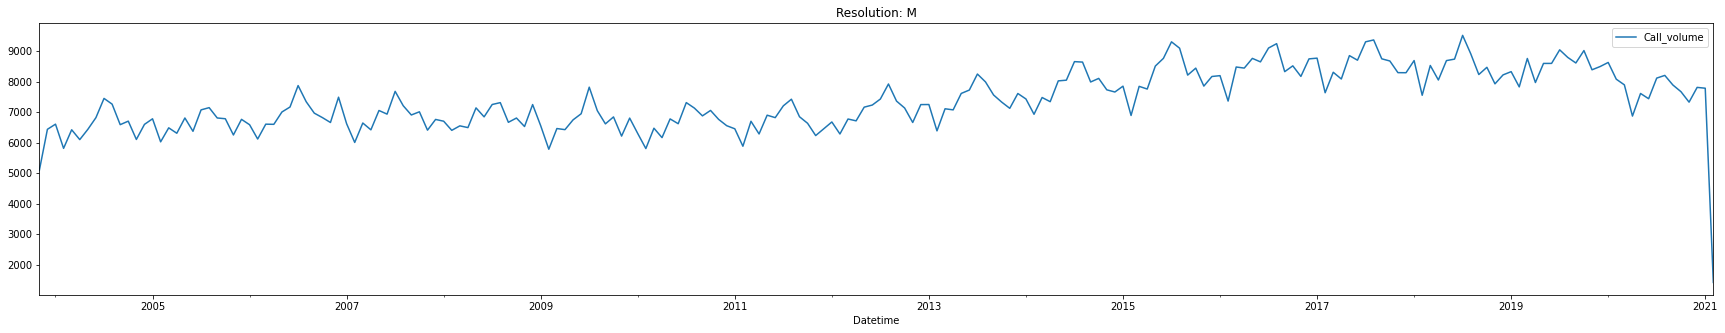

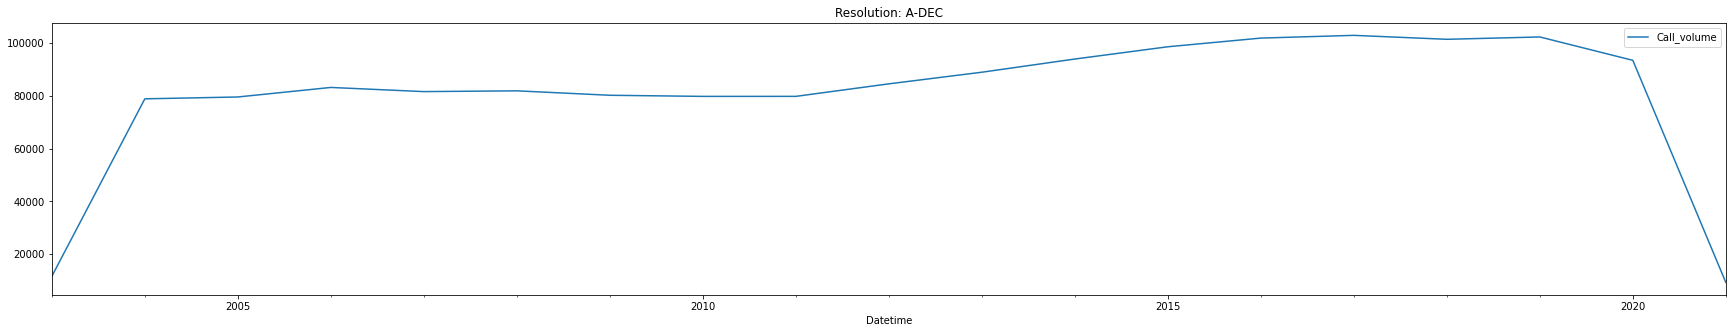

In [ ]:
# using custom function for plotting each calls_data resolution
plot_periods(calls_data_list)

From the hourly and daily plots we see several peaks. Let's find them:

In [ ]:
print(calls_data_H[(calls_data_H.index.year == 2006) | (calls_data_H.index.year == 2019)]['Call_volume'].nlargest(5))

Datetime
2006-12-15 09:00    68
2019-09-08 03:00    53
2006-12-15 01:00    48
2006-12-15 08:00    47
2006-12-15 10:00    38
Freq: H, Name: Call_volume, dtype: int64


A quick googling tells us that a windstorm hit Seattle on Dec 15, 2006 (Hanukkah Eve windstorm), i.e. this measurement is not an outlier. On Sep 7 (Sep 8 corrected for UTC) there were 200 lightning strikes in under an hour, that caused power knockouts and damages.
One can expect the weather information for these dates to be correlated with the high calls volume. This is an extreme example of weather data relevance for the calls volume. (There could also be some useful information in minimum call counts? *Use automatic anomally detection... Matrix Profile?*)


### Distinguish between types of calls?



In [ ]:
# stores all call type names in an array
types = calls_data.Type.unique()
print(f'There are {len(types)} distinct types of calls.')
types[:6]

There are 232 distinct types of calls.


array(['Medic Response', 'Auto Fire Alarm', '1RED 1 Unit',
       'Aid Response Yellow', 'Aid Response',
       'Medic Response, 7 per Rule'], dtype=object)

In [ ]:
types_data = calls_data.copy()
types_data.index = types_data.index.year
# add a column of ones to use a calls count
types_data['Count'] = 1
data1 = types_data.groupby(['Datetime', 'Type']).count().sort_values(by='Count', ascending=False)
data1

Count
Datetime Type                     
2017     Aid Response        53098
2016     Aid Response        52803
2018     Aid Response        51701
2015     Aid Response        50658
2019     Aid Response        49257
...                            ...
         Tunnel MVI Medic        1
2008     COMED Poss Patient      1
2019     Tunnel Car Fire         1
2015     Tunnel Aid              1
2011     W1RED - 1  Unit         1

[2014 rows x 1 columns]

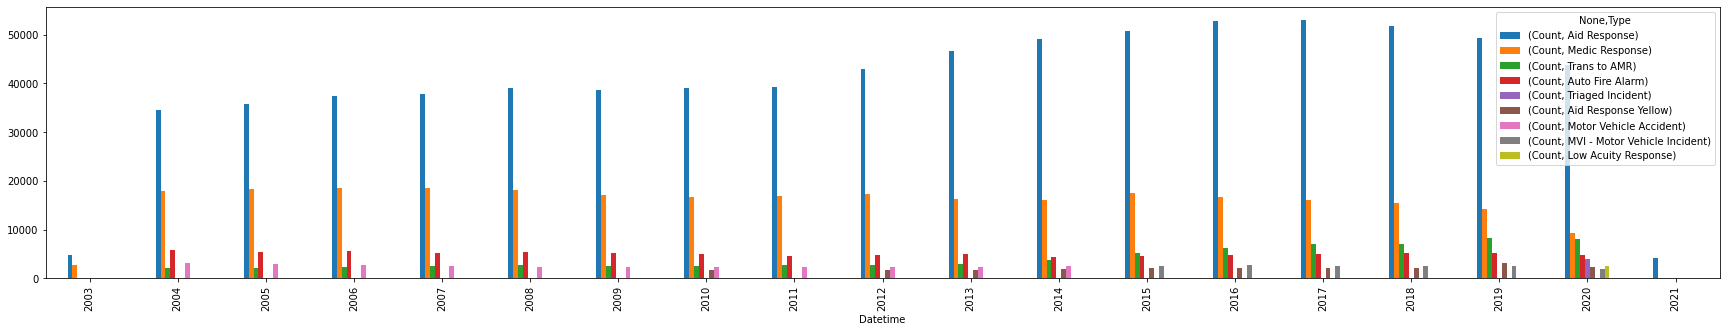

In [ ]:
data1[:100].unstack().plot(kind='bar', figsize=(30, 5))

We see that from 2015 we have 'Trans to AMR' type of calls appearing for the first time and in 2020 'Triaged Incident' for the first time. Also note that 'MVI' disappears from 2015 onward. Because of this, using different types of calls as e.g. features or series components, would require a separate and deeper understanding of data and its analysis (including classification of timeseries?).
Neverhtelss, a naive visual inspection of this data shows that the total calls follows the 'Aid Response'  trend.

## Weather data

In [ ]:
weather_path = os.path.abspath("Seattle_weather_data_2002_2020.csv")
# calls_path_dr = os.path.abspath("/content/drive/MyDrive/NiologicCodingChallenge/Seattle_weather_data_2002_2020.csv")

weather_data_raw = pd.read_csv(calls_path)
print(weather_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170996 entries, 0 to 170995
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   170996 non-null  int64  
 1   dt_iso               170996 non-null  object 
 2   timezone             170996 non-null  int64  
 3   city_name            170996 non-null  object 
 4   lat                  170996 non-null  float64
 5   lon                  170996 non-null  float64
 6   temp                 170996 non-null  float64
 7   feels_like           170996 non-null  float64
 8   temp_min             170996 non-null  float64
 9   temp_max             170996 non-null  float64
 10  pressure             170996 non-null  int64  
 11  sea_level            0 non-null       float64
 12  grnd_level           0 non-null       float64
 13  humidity             170996 non-null  int64  
 14  wind_speed           170996 non-null  float64
 15  wind_deg         

Initial observations:

*   There are 3 time-related columns. We check below that 'dt' is just UTC time (i.e. column 'dt_iso') in seconds.

*   Measurements appear to have been taken with hourly frequency (but there could be some skipped or repeated timestamps). 

*   Since we work with UTC time, 'timezone' column will not be of need and we can drop this column. This avoids DST shifts we encountered in calls dataset.

*   There are NaN values, but at least in columns 'rain_1h',	'rain_3h', 'snow_1h' and	'snow_3h' we can make sense of NaN values being zero, as in zero precipitation.


### Create an index with UTC Datetime

In [ ]:
# columns 'dt' and 'dt_iso' contain the same information
pd.Timestamp(weather_data_raw.at[13, 'dt'], unit='s') == pd.Timestamp(weather_data_raw.at[13, 'dt_iso'][:-10])

True

In [ ]:
weather_data = weather_data_raw.copy()
weather_data['Datetime'] = weather_data.pop('dt_iso').apply(lambda x: x[:-10]) # delete ' +0000 UTC' from the string
weather_data['Datetime'] = pd.to_datetime(weather_data['Datetime'], infer_datetime_format=True)
weather_data['Datetime'].head()

0   2002-01-01 00:00:00
1   2002-01-01 01:00:00
2   2002-01-01 02:00:00
3   2002-01-01 03:00:00
4   2002-01-01 04:00:00
Name: Datetime, dtype: datetime64[ns]

In [ ]:
# reset the index to Datetime
weather_data = weather_data.set_index('Datetime', drop=True)

### Handle NaN entries

Some columns are filled with NaN's entirely, some of them partially. The entirely NaN-filled columns we eliminate them using ``` drop_nan_cols() ``` defined in ```utils.py```. FOr the other columns with NaN values we assume they have a meaningful interpretation of zero precitipation.


In [ ]:
# finds columns with NaN's a drops them form the dataset
weather_data = drop_nan_cols(weather_data)
print('Columns with NaNs: ', weather_data.columns[weather_data.isna().any()].tolist())
# substitutes NaN's with zeros
weather_data = weather_data.fillna(0)
print(weather_data.info())

Columns with NaNs:  ['rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170996 entries, 2002-01-01 00:00:00 to 2020-11-04 23:00:00
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   170996 non-null  int64  
 1   timezone             170996 non-null  int64  
 2   city_name            170996 non-null  object 
 3   lat                  170996 non-null  float64
 4   lon                  170996 non-null  float64
 5   temp                 170996 non-null  float64
 6   feels_like           170996 non-null  float64
 7   temp_min             170996 non-null  float64
 8   temp_max             170996 non-null  float64
 9   pressure             170996 non-null  int64  
 10  humidity             170996 non-null  int64  
 11  wind_speed           170996 non-null  float64
 12  wind_deg             170996 non-null  int64  
 13  rain_1h             

### Examine duplicates and eliminate unnecessary columns

We will drop some columns. Appart from the ones with constant values such as 'lat' and 'lon', there are columns with descriptive entries. Some of these may be helpful as features and by inspection we can see that weather_id is the most useful one. We can also keep only 'temp' and 'feels_like' as temperature features.

In [ ]:
weather_data.head()

,dt,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
Datetime,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,1009843200,-28800,Seattle,47.606209,-122.332071,9.21,6.88,6.63,11.0,1019,71,1.50,40,0.0,0.0,0.0,0.0,75,803,Clouds,broken clouds,04d
2002-01-01 01:00:00,1009846800,-28800,Seattle,47.606209,-122.332071,8.20,6.20,4.64,10.0,1019,81,1.29,39,0.0,0.0,0.0,0.0,40,802,Clouds,scattered clouds,03n
2002-01-01 02:00:00,1009850400,-28800,Seattle,47.606209,-122.332071,6.61,4.16,4.03,8.5,1019,86,1.73,49,0.0,0.0,0.0,0.0,40,802,Clouds,scattered clouds,03n
2002-01-01 03:00:00,1009854000,-28800,Seattle,47.606209,-122.332071,6.43,3.82,3.29,7.6,1018,87,1.96,65,0.0,0.0,0.0,0.0,40,802,Clouds,scattered clouds,03n
2002-01-01 04:00:00,1009857600,-28800,Seattle,47.606209,-122.332071,6.25,3.36,3.26,7.4,1018,81,2.05,82,0.0,0.0,0.0,0.0,20,801,Clouds,few clouds,02n


In [ ]:
kill_cols = ['dt', 'timezone', 'city_name', 'lat', 'lon', 'temp_min', 'temp_max', 'clouds_all', 'weather_main', 'weather_description', 'weather_icon']
weather_data = weather_data.drop(labels=kill_cols, axis=1)

Have the data been taken each hour in this time interval? Let's check:

In [ ]:
# there are more entries than unique hourly timestamps - sign of duplication of dates
len(weather_data.index) - len(pd.unique(weather_data.index))

5804

Examination of table shows that weather_id is the only column that distinguishes among the duplicated entries.



In [ ]:
# checking duplicates with respect to index and e.g. temp column
weather_data.value_counts(subset=[weather_data.index, 'temp'])

Datetime             temp 
2019-02-04 01:00:00  0.08     3
2019-02-11 19:00:00  0.67     3
2007-09-27 18:00:00  12.90    3
2007-09-27 17:00:00  12.15    3
2020-07-12 17:00:00  13.91    3
                             ..
2014-06-05 03:00:00  17.08    1
2014-06-05 02:00:00  18.43    1
2014-06-05 01:00:00  18.59    1
2014-06-05 00:00:00  18.22    1
2002-01-01 00:00:00  9.21     1
Length: 165192, dtype: int64

In [ ]:
weather_data[weather_data.index.duplicated(keep=False) == True].head()

,temp,feels_like,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,weather_id
Datetime,,,,,,,,,,,
2002-01-07 17:00:00,12.98,10.75,1008,87,3.6,140,1.80,0.0,0.0,0.0,501
2002-01-07 17:00:00,12.98,10.75,1008,87,3.6,140,1.80,0.0,0.0,0.0,701
2002-01-08 19:00:00,10.41,6.21,1017,81,5.1,180,0.50,0.0,0.0,0.0,500
2002-01-08 19:00:00,10.41,6.21,1017,81,5.1,180,0.50,0.0,0.0,0.0,701
2002-01-08 22:00:00,10.45,7.45,1018,76,3.1,210,0.37,0.0,0.0,0.0,500


We could turn weather_id column's unique vlaues into own columns, whose entries will be 0 or 1, indicating the presence of particular weather_id in each date. In this way duplicates would be eliminated without any loss of data. The price is the inclusion of additional features (that we may or may not take into account). (Alternatively, one could figure out a way to have a single column with values uniquely designating all present combinations of weather_id.). For simplicity of the initial model iteration, we drop this column.

In [ ]:
weather_data_unq = weather_data.copy()
weather_data_unq.pop('weather_id')
# drop duplicates
weather_data_unq.drop_duplicates(inplace=True)
weather_data_unq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165121 entries, 2002-01-01 00:00:00 to 2020-11-04 23:00:00
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   temp        165121 non-null  float64
 1   feels_like  165121 non-null  float64
 2   pressure    165121 non-null  int64  
 3   humidity    165121 non-null  int64  
 4   wind_speed  165121 non-null  float64
 5   wind_deg    165121 non-null  int64  
 6   rain_1h     165121 non-null  float64
 7   rain_3h     165121 non-null  float64
 8   snow_1h     165121 non-null  float64
 9   snow_3h     165121 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 13.9 MB


We now have weather dataset with unique hourly entries.

## Merge calls data and weather data

### Data selection

In order to join the calls volume ```calls_data_H``` and weather data ```weather_data_unq``` on the index, their respective indexes need to be of the same format. We see below that there are more calls data than weather data.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62105 entries, 2014-01-01 00:00:00 to 2021-02-07 00:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Call_volume  62105 non-null  int64
dtypes: int64(1)
memory usage: 970.4 KB
None


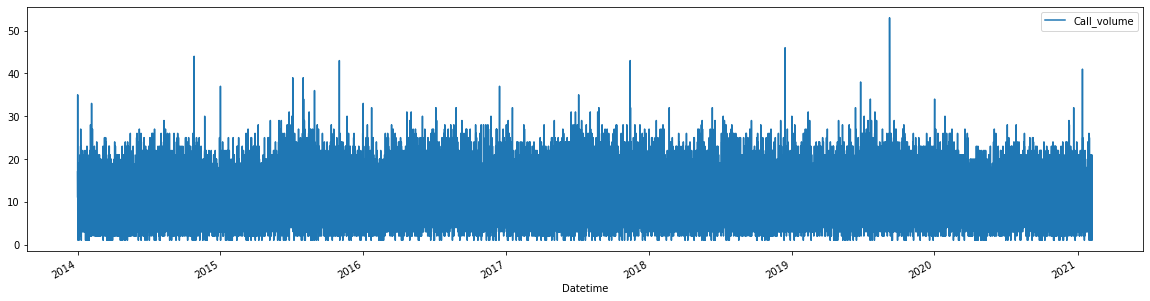

In [ ]:
# create a copy of calls hourly data starting from 2013
calls_data_ts = calls_data_H[calls_data_H.index.year > 2013].copy()

# turn periodIndex to timestamp, to make it compatible with weather data
calls_data_ts.index = calls_data_ts.index.to_timestamp()
print(calls_data_ts.info())
calls_data_ts.plot(figsize=(20, 5))

In [ ]:
# add weather features to calls data for weather data's timestamps only
calls_weather_ts = calls_data_ts.join(weather_data_unq, how='inner')
calls_weather_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59810 entries, 2014-01-01 00:00:00 to 2020-11-04 23:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Call_volume  59810 non-null  int64  
 1   temp         59810 non-null  float64
 2   feels_like   59810 non-null  float64
 3   pressure     59810 non-null  int64  
 4   humidity     59810 non-null  int64  
 5   wind_speed   59810 non-null  float64
 6   wind_deg     59810 non-null  int64  
 7   rain_1h      59810 non-null  float64
 8   rain_3h      59810 non-null  float64
 9   snow_1h      59810 non-null  float64
 10  snow_3h      59810 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 5.5 MB


We can use ```calls_data_ts``` dataset for predicting the calls volume based only on calls volume history (by deriving features from calls volume past data).
On the other hand, with ```calls_weather_ts``` dataset we can investigate the effect of weather conditions as predictors of calls volume, in addition to calls volume past history.
However, it is important to keep in mind that these two datasets are of different sizes - ```calls_weather_ts``` spans a period only until ```2020-11-04 23:00:00```.



In [ ]:
print(f'Calls volume data available from {calls_data_ts.index[0]} to {calls_data_ts.index[-1]} \nCalls plus weather data available from {calls_weather_ts.index[0]} to {calls_weather_ts.index[-1]}')

Calls volume data available from 2014-01-01 00:00:00 to 2021-02-07 00:00:00 
Calls plus weather data available from 2014-01-01 00:00:00 to 2020-11-04 23:00:00


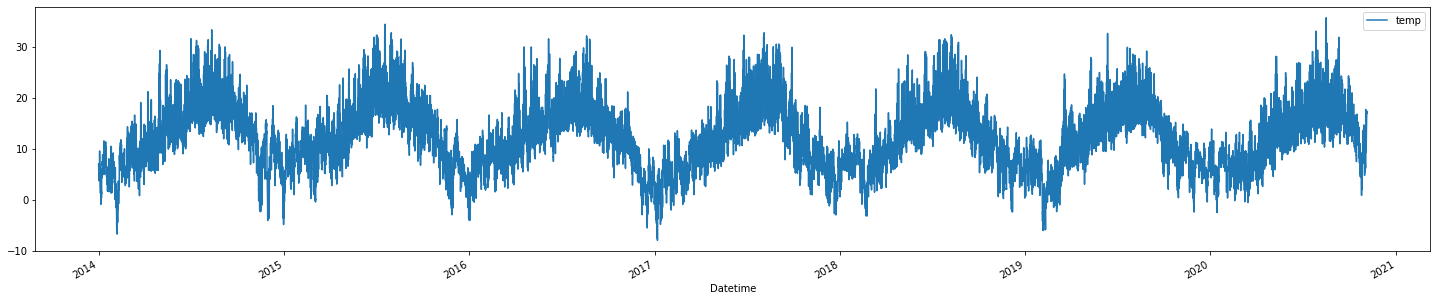

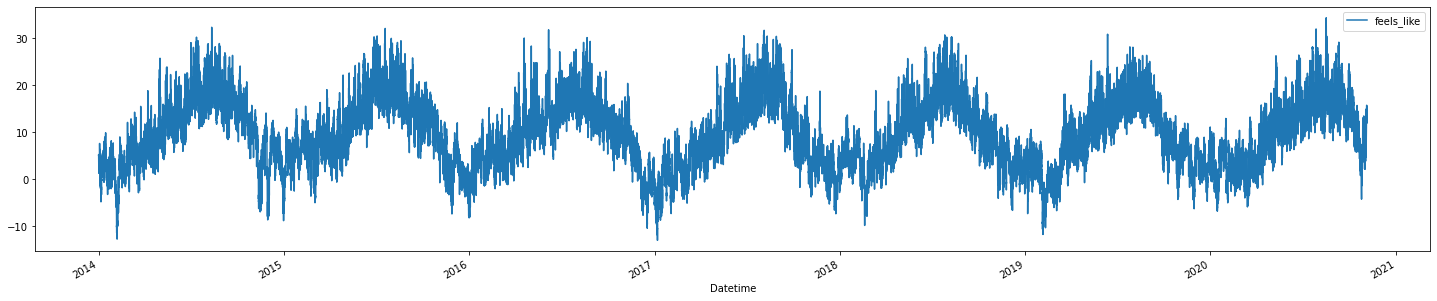

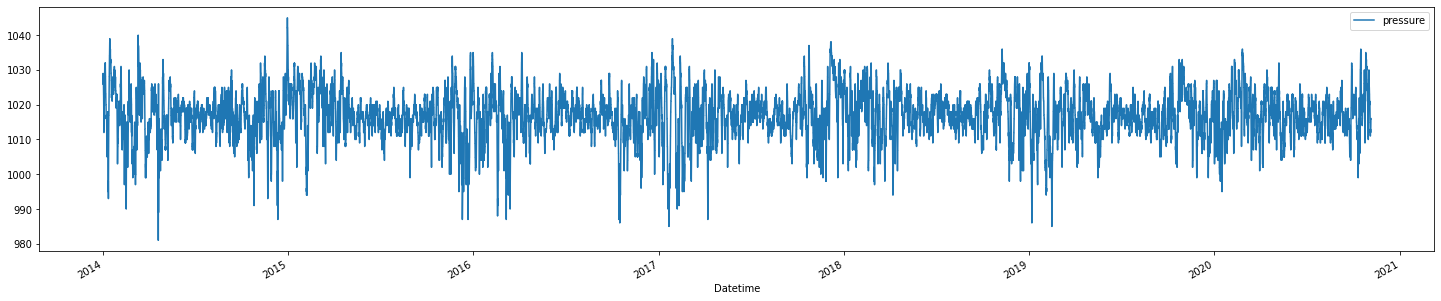

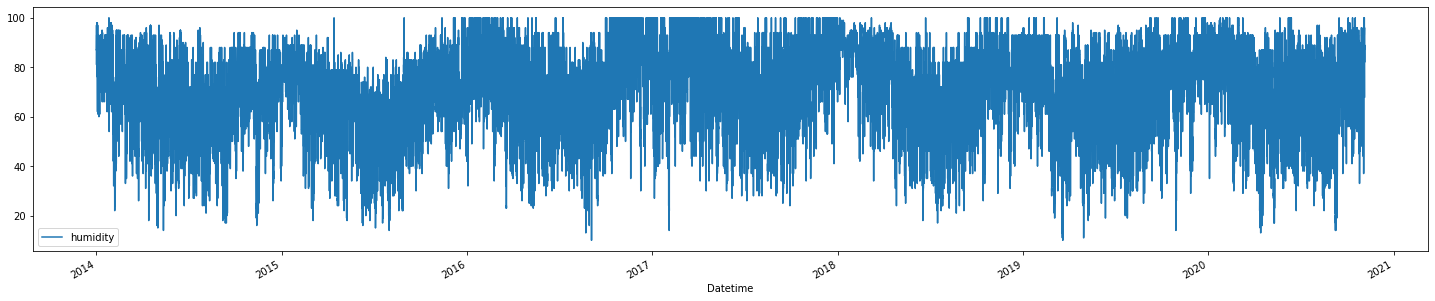

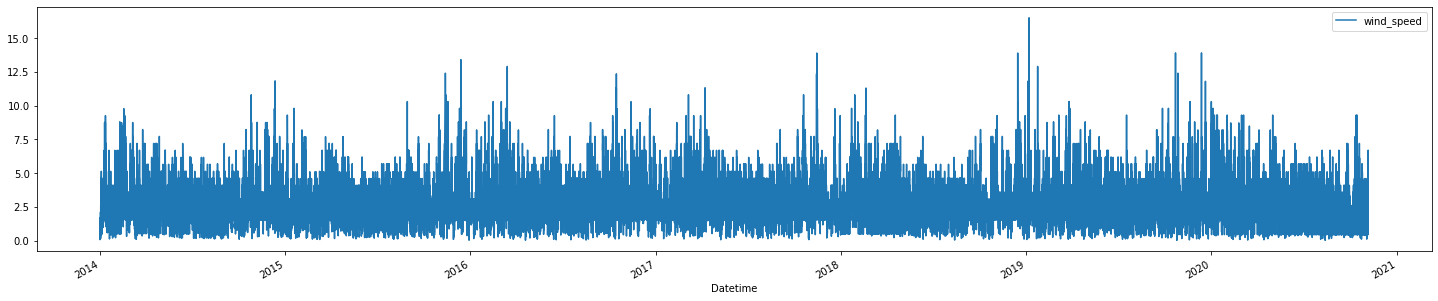

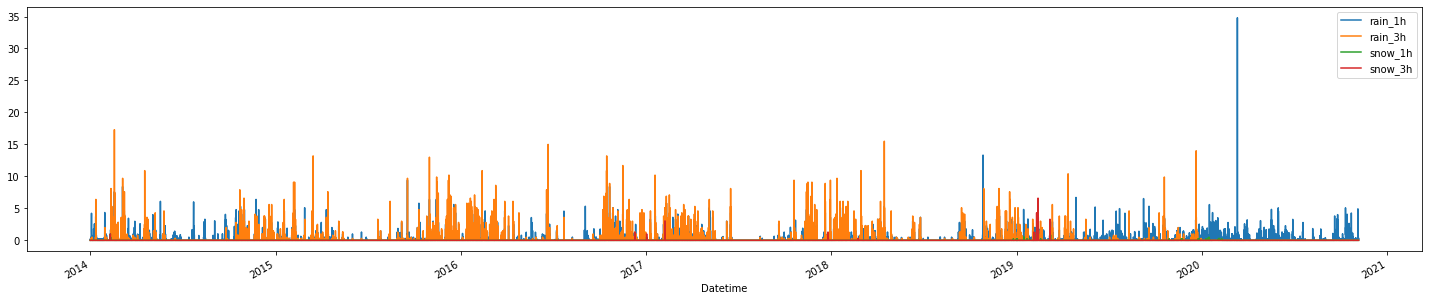

In [ ]:
calls_weather_ts[['temp']].plot(figsize=(25, 5))
calls_weather_ts[['feels_like']].plot(figsize=(25, 5))
calls_weather_ts[['pressure']].plot(figsize=(25, 5))
calls_weather_ts[['humidity']].plot(figsize=(25, 5))
calls_weather_ts[['wind_speed']].plot(figsize=(25, 5))
calls_weather_ts[['rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']].plot(figsize=(25, 5))

Wind speed is described by a number (length of wind vector) and an angle. The problem with angle is that 0 and 360 are the same directions. We will treat this problem in Feature Engineering section below.

These series need to be investigated independently of calls volume data. One reason is that, e.g. the variable long-term trend present in the call volume data is not present for the weather. This suggests to look for the causes of call volume trend elsewhere.

But seasonality, on the other hand, is prominent in weather data as well.

*Trend + Season + cyclicity decomposition?*

'feels_like' is a measure of temmperature derived from temperature and humidity as a non-linear function.l Therefore, we could drop temp and humidity and keep the rest. *(But this needs to be explored using some feature importance evaluation methods.)*

In [ ]:
calls_weather_ts.columns

Index(['Call_volume', 'temp', 'feels_like', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h'],
      dtype='object')

In [ ]:
calls_weather_ts1 = calls_weather_ts[['Call_volume', 'feels_like', 'pressure',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']].copy()

# Feature engineering

## Hourly, daily, weekly, and yearly periods

(this secton is inspired by TensorFlow timeseries tutorial)

Visual examination of calls data showed yearly, seasonal and daily periodic change of calls volume. But there could be other modes that could serve as a good basis for features. This could be investigated using Fourier spectrum.

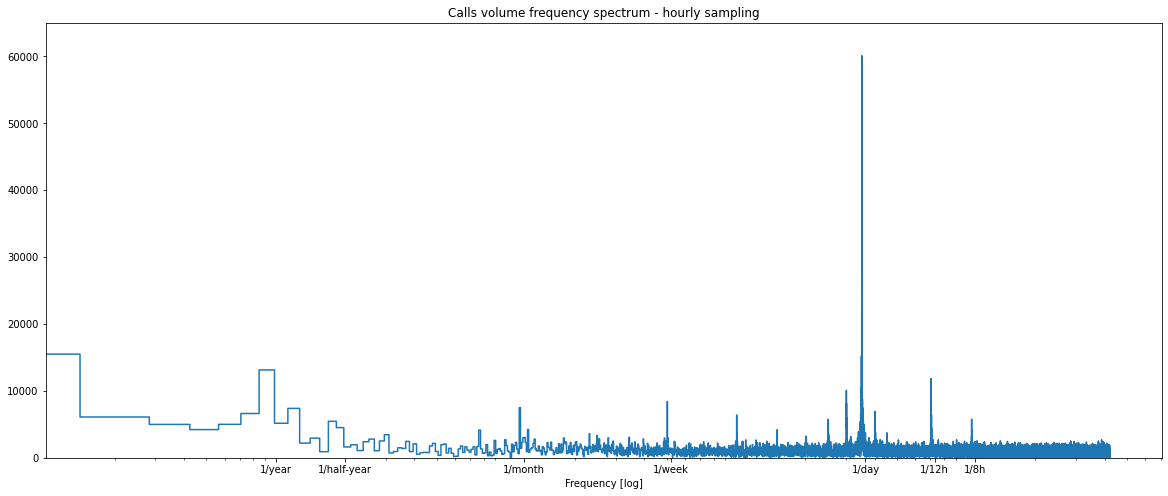

In [ ]:
# use tensorflow's real fast Fourier transform to get the frequency spectrum of calls data
calls_freq_spect = tf.signal.rfft(calls_weather_ts1['Call_volume'])
freq_range = np.arange(0, len(calls_freq_spect))
total_data_hrs = len(calls_data_ts)

# amount of yearly periods that span the frequency spectrum
years_range = total_data_hrs/hrs_per_year

# amount of yearly frequencies that span the frequency spectrum
freq_per_year = freq_range/years_range

plt.figure(figsize=(20, 8))
plt.title(label='Calls volume frequency spectrum - hourly sampling')
plt.step(freq_per_year, np.abs(calls_freq_spect))
plt.xscale('log')
plt.ylim(0, 65000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 2, 12, 365.2524/7, 365.2524, 2*365.2524, 3*365.2524], labels=['1/year', '1/half-year', '1/month', '1/week', '1/day', '1/12h', '1/8h'])
_ = plt.xlabel('Frequency [log]')

We see a clear daily and yearly frequency. There are 12-hour periods as well, which can be expected due to day-night change. There are also (possibly harmonics) frequencies around the daily mode, some of which are relatively stronger than the weekly mode. 
It is also interesting that the 'monthly' period corresponds to an average month length ```365.2524/12 ~ 30.44``` days.
Here we use 'intuitive' and for everyday life relatively relevant modes, such as yearly, monthly, daily and weekly.
In more detailed analysis, however, it could be worthwile and more precise to extract the most relevant frequencies from the Fourier spectrum automatically. (*Use Matrix Profile to find motifs, discords and anomalies - special events and holidays?*)

The same can be done with temperature (i.e. feels_like temperature) and similar frequencies emerge. Yearly period is quite prominent. Weekly and monthly do not appear to be well-defined as in calls volume - this is expected, since calls volume has additional constraints of social character.


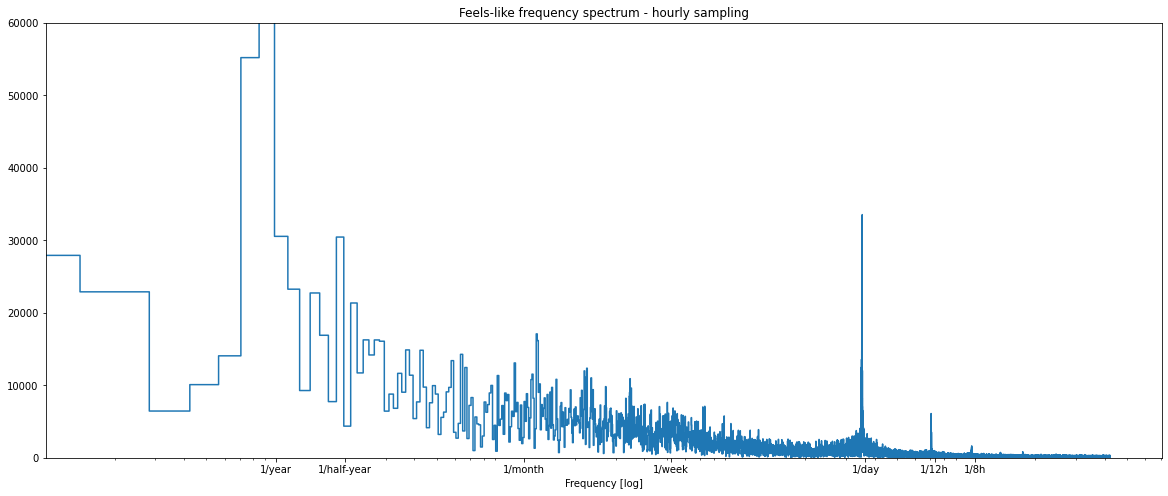

In [ ]:
feel_temp_freq_spect = tf.signal.rfft(calls_weather_ts1['feels_like'])
freq_range = np.arange(0, len(feel_temp_freq_spect))
total_data_hrs = len(calls_data_ts)

# amount of yearly periods that span the frequency spectrum
years_range = total_data_hrs/hrs_per_year

# amount of yearly frequencies that span the frequency spectrum
freq_per_year = freq_range/years_range

plt.figure(figsize=(20, 8))
plt.title(label='Feels-like frequency spectrum - hourly sampling')
plt.step(freq_per_year, np.abs(feel_temp_freq_spect))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 2, 12, 365.2524/7, 365.2524, 2*365.2524, 3*365.2524], labels=['1/year', '1/half-year', '1/month', '1/week', '1/day', '1/12h', '1/8h'])
_ = plt.xlabel('Frequency [log]')

Turn datetime stamps into features extracted from the Fourier spectrum:

In [ ]:
# datetime timestamp index converted to date in hours
datetime_hrs = calls_weather_ts1.index.map(datetime.datetime.timestamp) / 3600

Seasonality is captured at 4 different resolutions, such that each timestamp is uniquely designated by a 8-dim vector with values between -1 and 1.

## Preparing the weather data

In [ ]:
calls_weather_feat = calls_weather_ts1.copy()
# use custom function to generate colums with cos/sin representations of Datetime
calls_weather_feat = osc_to_cartesian(calls_weather_feat, datetime_hrs, periods_dict)
print(calls_weather_feat.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59810 entries, 2014-01-01 00:00:00 to 2020-11-04 23:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Call_volume  59810 non-null  int64  
 1   feels_like   59810 non-null  float64
 2   pressure     59810 non-null  int64  
 3   wind_speed   59810 non-null  float64
 4   wind_deg     59810 non-null  int64  
 5   rain_1h      59810 non-null  float64
 6   rain_3h      59810 non-null  float64
 7   snow_1h      59810 non-null  float64
 8   snow_3h      59810 non-null  float64
 9   D_cos        59810 non-null  float64
 10  W-MON_cos    59810 non-null  float64
 11  M_cos        59810 non-null  float64
 12  Y_cos        59810 non-null  float64
 13  D_sin        59810 non-null  float64
 14  W-MON_sin    59810 non-null  float64
 15  M_sin        59810 non-null  float64
 16  Y_sin        59810 non-null  float64
dtypes: float64(14), int64(3)
memory usage: 8.2 MB
None


We normalize the pressure values by dividing them by the standard average atmospheric pressure at the sea level - 1013.25 mbars.

In [ ]:
calls_weather_feat['pressure'] = calls_weather_feat['pressure'] / 1013.25

In [ ]:
calls_weather_feat.head()

,Call_volume,feels_like,pressure,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,D_cos,W-MON_cos,M_cos,Y_cos,D_sin,W-MON_sin,M_sin,Y_sin
Datetime,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,17,5.11,1.012583,1.14,195,0.00,0.0,0.0,0.0,1.000000,0.623490,0.999762,0.999998,-1.067931e-11,-0.781831,-0.021797,-0.001817
2014-01-01 01:00:00,15,4.39,1.012583,1.54,330,0.00,0.0,0.0,0.0,0.965926,0.652287,0.999913,0.999999,2.588190e-01,-0.757972,-0.013197,-0.001100
2014-01-01 02:00:00,14,5.21,1.013570,0.08,181,0.25,0.0,0.0,0.0,0.866025,0.680173,0.999989,1.000000,5.000000e-01,-0.733052,-0.004596,-0.000383
2014-01-01 03:00:00,12,4.54,1.013570,0.51,212,0.00,0.0,0.0,0.0,0.707107,0.707107,0.999992,1.000000,7.071068e-01,-0.707107,0.004005,0.000334
2014-01-01 04:00:00,15,3.88,1.013570,0.66,62,0.00,0.0,0.0,0.0,0.500000,0.733052,0.999921,0.999999,8.660254e-01,-0.680173,0.012606,0.001050


The wind direction is deisgnated by degrees in wind_deg column. But 0 and 360 degs are the same direction. Hence, the two wind columns are wind direction and speed in polar coordinates.

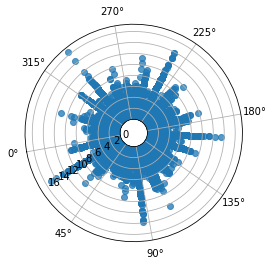

In [ ]:
phi = calls_weather_feat['wind_deg']
r = calls_weather_feat['wind_speed']

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.scatter(phi.values, r.values, cmap='hsv', alpha=0.75)

ax.set_rorigin(-2.5)
ax.set_theta_zero_location('W', offset=10)

To resolve this ambiguity we can use a trick to transform them into cartesian coordinates, giving each point a unique pair of values.

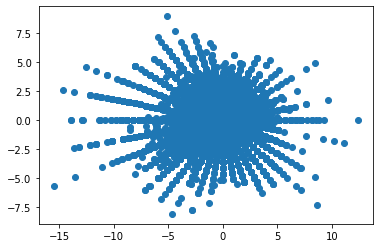

In [ ]:
calls_weather_feat['wind_cos'] = r * np.cos(phi * np.pi / 180)
calls_weather_feat['wind_sin'] = r * np.sin(phi * np.pi / 180)

plt.scatter(calls_weather_feat['wind_cos'], calls_weather_feat['wind_sin'])     # needs more options set

## Introduce lag features

Assume that predicted calls volume for the next time point depends on previous time points. Since the timeseries has a trend (seen upon visual inspection), it would be good to include first and second differences (derivatives, ) of data.

In [ ]:
# introduce columns shifted by 1 and 2 steps from the past into the future timestamp
calls_weather_feat['i-1'] = calls_weather_feat['Call_volume'].shift()
calls_weather_feat['i-2'] = calls_weather_feat['Call_volume'].shift(2)

# introduce a column with the first difference
calls_weather_feat['diff1'] = calls_weather_feat['i-1'].diff()
# introduce a column with the second difference
calls_weather_feat['diff2'] = (calls_weather_feat['Call_volume'] - 2 * calls_weather_feat['diff1'] + calls_weather_feat['i-2'])

# frop NaN rows that appeared due to 
calls_weather_feat = calls_weather_feat.dropna()

In [ ]:
calls_weather_feat.head()

,Call_volume,feels_like,pressure,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,D_cos,W-MON_cos,M_cos,Y_cos,D_sin,W-MON_sin,M_sin,Y_sin,wind_cos,wind_sin,i-1,i-2,diff1,diff2
Datetime,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 02:00:00,14,5.21,1.013570,0.08,181,0.25,0.0,0.0,0.0,8.660254e-01,0.680173,0.999989,1.000000,0.500000,-0.733052,-0.004596,-0.000383,-0.079988,-0.001396,15.0,17.0,-2.0,35.0
2014-01-01 03:00:00,12,4.54,1.013570,0.51,212,0.00,0.0,0.0,0.0,7.071068e-01,0.707107,0.999992,1.000000,0.707107,-0.707107,0.004005,0.000334,-0.432505,-0.270259,14.0,15.0,-1.0,29.0
2014-01-01 04:00:00,15,3.88,1.013570,0.66,62,0.00,0.0,0.0,0.0,5.000000e-01,0.733052,0.999921,0.999999,0.866025,-0.680173,0.012606,0.001050,0.309851,0.582745,12.0,14.0,-2.0,33.0
2014-01-01 05:00:00,16,3.64,1.013570,0.27,52,0.00,0.0,0.0,0.0,2.588190e-01,0.757972,0.999775,0.999998,0.965926,-0.652287,0.021205,0.001767,0.166229,0.212763,15.0,12.0,3.0,22.0
2014-01-01 06:00:00,11,3.16,1.014557,0.32,353,0.00,0.0,0.0,0.0,1.324265e-11,0.781831,0.999556,0.999997,1.000000,-0.623490,0.029804,0.002484,0.317615,-0.038998,16.0,15.0,1.0,24.0


# Preprocessing

For example, we choose to normalize the entire feature row as a unit vector, using L2 norm. This is useful because: 1) all features that we did not process will be also affected automatically; 2) normalized values do not depend appending future data (i.e. new rows); 3) gives equal initial impportance to all features...?

In [ ]:
rescaler = Normalizer(norm = 'l2')
calls_weather_resc = calls_weather_feat.copy()

features_names = calls_weather_resc.columns.tolist()[1:]
features = calls_weather_resc[features_names]

# normalize only features
calls_weather_resc[features_names] = rescaler.fit_transform(features.values)

calls_weather_resc.head()

,Call_volume,feels_like,pressure,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,D_cos,W-MON_cos,M_cos,Y_cos,D_sin,W-MON_sin,M_sin,Y_sin,wind_cos,wind_sin,i-1,i-2,diff1,diff2
Datetime,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 02:00:00,14,0.028035,0.005454,0.000430,0.973960,0.001345,0.0,0.0,0.0,4.660077e-03,0.003660,0.005381,0.005381,0.002690,-0.003945,-0.000025,-0.000002,-0.000430,-0.000008,0.080715,0.091477,-0.010762,0.188335
2014-01-01 03:00:00,12,0.021114,0.004714,0.002372,0.985960,0.000000,0.0,0.0,0.0,3.288579e-03,0.003289,0.004651,0.004651,0.003289,-0.003289,0.000019,0.000002,-0.002011,-0.001257,0.065111,0.069761,-0.004651,0.134872
2014-01-01 04:00:00,15,0.053306,0.013925,0.009068,0.851800,0.000000,0.0,0.0,0.0,6.869355e-03,0.010071,0.013738,0.013739,0.011898,-0.009345,0.000173,0.000014,0.004257,0.008006,0.164865,0.192342,-0.027477,0.453377
2014-01-01 05:00:00,16,0.060798,0.016930,0.004510,0.868548,0.000000,0.0,0.0,0.0,4.323014e-03,0.012660,0.016699,0.016703,0.016134,-0.010895,0.000354,0.000030,0.002776,0.003554,0.250543,0.200434,0.050109,0.367463
2014-01-01 06:00:00,11,0.008914,0.002862,0.000903,0.995721,0.000000,0.0,0.0,0.0,3.735409e-14,0.002205,0.002819,0.002821,0.002821,-0.001759,0.000084,0.000007,0.000896,-0.000110,0.045132,0.042311,0.002821,0.067698


# Train model

### Train-validation-test split

Use backtesting, with expanding window method. We split the data into trainval set and test set. The trainval set is further split into several pairs of train and validation sets using ```TimeSeriesSplit``` from ```sklearn```.

* ```calls_trainval```
    * train set
        * ```X_train``` (features)
        * ```y_train``` (calls - labels)
    * validation set
        * ```X_val``` (features)
        * ```y_val``` (calls - labels)

* Test set = ```calls_test```
    * ```X_test```
    * ```y_test```

Using timestamps and indexes, we can chop the dataset how we want.

In [ ]:
calls_weather_resc.index

DatetimeIndex(['2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               '2014-01-01 10:00:00', '2014-01-01 11:00:00',
               ...
               '2020-11-04 14:00:00', '2020-11-04 15:00:00',
               '2020-11-04 16:00:00', '2020-11-04 17:00:00',
               '2020-11-04 18:00:00', '2020-11-04 19:00:00',
               '2020-11-04 20:00:00', '2020-11-04 21:00:00',
               '2020-11-04 22:00:00', '2020-11-04 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=59808, freq=None)

In [ ]:
# define daily, weekly, and monthly forecasting window - these will be available forecasting windows
day_forecast = hrs_per_day
week_forecast = hrs_per_week
month_forecast = np.floor(hrs_per_month).astype(int)

# choose forecast window
forecast_window = week_forecast

In [ ]:
# designate a date and the corresponding index of the end of the train + validation set
split_timestamp = "2019-01-01 00:00:00"   # if we want to use 2019 as test (forecast) year
split_index = calls_weather_resc.index.get_loc(split_timestamp)

# designate a date and the corresponding index of the end of the test (forecast) set
pred_timestamp_year = "2020-01-01 00:00:00"     # we can include jan and feb if we wish
pred_index_year = calls_weather_resc.index.get_loc(pred_timestamp_year)

print(f'Train and validation dataset ends on date {split_timestamp} (index = {split_index}) \
        \nPrediction/Test dataset ends on date {pred_timestamp_year} (index = {pred_index_year}, size = {pred_index_year - split_index})')

# split train + val set from test set; test set is not involved in training and model selection
calls_trainval = calls_weather_resc.iloc[:split_index].copy()
calls_test = calls_weather_resc.iloc[len(calls_trainval):pred_index_year].copy()

Train and validation dataset ends on date 2019-01-01 00:00:00 (index = 43670)         
Prediction/Test dataset ends on date 2020-01-01 00:00:00 (index = 52418, size = 8748)


In [ ]:
# extract features and labels from training data (to be split to train+val) and
# turn them into numpy arrays
X_trainval = np.array(calls_trainval[features_names].values)
y_trainval = np.array(calls_trainval['Call_volume'].values)

X_test = np.array(calls_test[features_names].values)
y_test = np.array(calls_test['Call_volume'].values)

In [ ]:
# if this line gives a test_size error, please make sure version 0.24.1 of scikit-learn is installed!
TS_split = TimeSeriesSplit(n_splits=5, test_size=week_forecast)
print(TS_split)

# e.g. this is how the expanding window with week forecast looks like
def split_ts_train_val(X_trainval, y_trainval, TS_split):
    for train_index, val_index in TS_split.split(X_trainval):
        print(f'Train data: {train_index}, Validation data: {val_index}')
        # select train features set and train labels set from features and labels
        X_y_train = (X_trainval[train_index], y_trainval[train_index])
        X_y_val = (X_trainval[val_index], y_trainval[val_index])

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=168)


## RandomForestRegressor (UNFINISHED)

In [ ]:
model = RandomForestRegressor(n_estimators=50)

# calculate cross-validation performance of the training
RFR_cv_results = cross_val_score(model, X_trainval, y_trainval, cv=TS_split, scoring='r2')

# print errors for each pass, their mean and their standard deviation
print(RFR_cv_results, RFR_cv_results.mean(), RFR_cv_results.std())

[0.78697176 0.7532866  0.79921311 0.84466977 0.79448459] 0.795725167253648 0.02928116381187574


Use GridSearchCV to find the optimal set of hyperparameters during backtesting...

In [ ]:
# grid_search...

## Training with XGBoost (UNFINISHED)

(inspired by kaggle tutorial)

In [ ]:
def train_xgb_model(the_model, X_trainval, y_trainval, TS_split, eval_metrics):

    results = []

    for train_index, val_index in TS_split.split(X_trainval):

        # print(f'Train data: {len(train_index)}, Validation data: {len(val_index)}')

        # select train features set and train labels set from features and labels
        X_y_train = (X_trainval[train_index], y_trainval[train_index])

        X_y_val = (X_trainval[val_index], y_trainval[val_index])

        # we use TimeSeriesSplit to evaluate the metrics on each expanding window pass
        the_model.fit(X_y_train[0], X_y_train[1], eval_metric=eval_metrics, eval_set=[X_y_train, X_y_val],
              early_stopping_rounds=50, verbose=False)
        
        results.append(the_model.evals_result())

    return results

In [ ]:
the_model = xgb.XGBRegressor(n_estimators=200)
eval_metrics = "rmse"

In [ ]:
xgb_train_cv_score = train_xgb_model(the_model, X_trainval, y_trainval, TS_split, eval_metrics)

# this could be useful... maybe...
xgb_df = pd.DataFrame(xgb_train_cv_score)
xgb_df.head()

[14:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,validation_0,validation_1
0,"{'rmse': [10.997111, 10.044327, 9.199441, 8.45...","{'rmse': [10.908083, 9.944176, 9.08774, 8.3349..."
1,"{'rmse': [10.996713, 10.043935, 9.199165, 8.45...","{'rmse': [10.831596, 9.896316, 9.057526, 8.323..."
2,"{'rmse': [10.996163, 10.043493, 9.19866, 8.452...","{'rmse': [11.469743, 10.529855, 9.7035, 8.9708..."
3,"{'rmse': [10.998142, 10.045403, 9.200655, 8.45...","{'rmse': [10.704957, 9.732502, 8.865786, 8.097..."
4,"{'rmse': [10.996944, 10.044284, 9.199324, 8.45...","{'rmse': [9.028789, 8.09344, 7.258084, 6.53290..."


...Plot train vs validation errors...


## Prediction on the test set (NEEDS POLISHING)

In [ ]:
res_df = pd.DataFrame(y_predict)

In [ ]:
# make predictions for the call volume for year 2019
y_predict = the_model.predict(X_test)

In [ ]:
mse_calls = mean_squared_error(y_test, y_predict)
rmse_calls = np.sqrt(mse_calls)
# root mean squared error
rmse_calls

2.4169121074698063

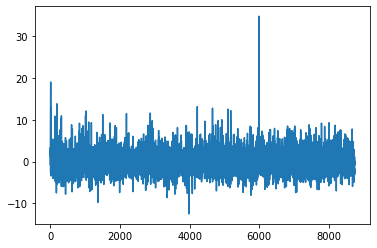

In [ ]:
plt.plot(np.arange(len(y_predict)), y_test - y_predict, label='Prediction error for the year 2019')